In [1]:
# 모듈 import

from mmcv import Config
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets import (build_dataloader, build_dataset, replace_ImageToTensor)
from mmdet.utils import get_device

import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
# config file 들고오기
cfg = Config.fromfile('./configs/detectors/custom_cascade_rcnn.py')

root='/data/ephemeral/home/dataset/'

cfg.keys()

dict_keys(['model', 'dataset_type', 'data_root', 'img_norm_cfg', 'train_pipeline', 'test_pipeline', 'data', 'evaluation', 'optimizer', 'optimizer_config', 'lr_config', 'runner', 'checkpoint_config', 'log_config', 'custom_hooks', 'dist_params', 'log_level', 'load_from', 'resume_from', 'workflow', 'opencv_num_threads', 'mp_start_method', 'auto_scale_lr'])

In [3]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# dataset config 수정

cfg.data.train.classes = classes
# cfg.data.train.dataset.classes = classes
cfg.data.train.img_prefix = root
# cfg.data.train.dataset.img_prefix = root
cfg.data.train.ann_file = root + 'train_split.json' # train json 정보
# cfg.data.train.dataset.ann_file = root + 'train_split.json' # train json 정보
# cfg.data.train.pipeline[2]['img_scale'] = (1024, 1024) # Resize

cfg.data.val.classes = classes
cfg.data.val.img_prefix = root
cfg.data.val.ann_file = root + 'val_split.json' # train json 정보'
# cfg.data.val.pipeline[1].transforms[0]['img_scale'] = (1024, 1024) # Resize

cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json' # test json 정보
# cfg.data.test.pipeline[1].transforms[0]['img_scale'] = (1024, 1024) # Resize

cfg.data.samples_per_gpu = 8 # 한 GPU가 학습 시 한 번에 처리할 이미지(샘플)의 개수(배치 크기 조절)
cfg.data.workers_per_gpu = 4 # 한 GPU가 데이터를 불러올 때 병렬로 작업할 워커(worker)의 수

cfg.seed = 2024
cfg.gpu_ids = [0]
# cfg.work_dir = './work_dirs/custom_cascade(Shear,Rotate,Translate,RandomShift,MinIoURandomCrop)_log'
cfg.work_dir = './work_dirs/faster_rcnn_base_log'

# cfg.model.roi_head.bbox_head.num_classes = 10
for i in range(3):
    cfg.model.roi_head.bbox_head[i].num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2) # 학습 중 기울기 폭발을 방지하기 위해 사용
cfg.checkpoint_config = dict(max_keep_ckpts=3, interval=1) # 최대 3개의 체크포인트 파일을 유지

cfg.log_config = dict(
    interval=50,  # 로그를 50 iteration마다 출력
    hooks=[
        dict(type='TextLoggerHook'),  # 기본 Text Logger
        dict(type='TensorboardLoggerHook'),  # Tensorboard Logger 추가
    ])

cfg.evaluation = dict(
    interval=1,
    metric='bbox',
    save_best='auto',
    by_epoch=True
)

cfg.device = get_device()

In [4]:
# build_dataset

datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [5]:
datasets[0]


CocoDataset Train dataset with number of images 3914, and instance counts: 
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+
| category          | count | category      | count | category        | count | category    | count | category     | count |
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+
| 0 [General trash] | 3161  | 1 [Paper]     | 5115  | 2 [Paper pack]  | 706   | 3 [Metal]   | 769   | 4 [Glass]    | 835   |
| 5 [Plastic]       | 2350  | 6 [Styrofoam] | 1026  | 7 [Plastic bag] | 4151  | 8 [Battery] | 143   | 9 [Clothing] | 377   |
+-------------------+-------+---------------+-------+-----------------+-------+-------------+-------+--------------+-------+

In [6]:
datasets[0][0]

{'img_metas': DataContainer({'filename': '/data/ephemeral/home/dataset/train/0000.jpg', 'ori_filename': 'train/0000.jpg', 'ori_shape': (1024, 1024, 3), 'img_shape': (806, 1024, 3), 'pad_shape': (832, 1024, 3), 'scale_factor': array([1.9104477, 1.9099526, 1.9104477, 1.9099526], dtype=float32), 'flip': True, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([0., 0., 0.], dtype=float32), 'std': array([1., 1., 1.], dtype=float32), 'to_rgb': False}}),
 'img': DataContainer(tensor([[[109., 109., 108.,  ...,  92., 102., 107.],
          [108., 108., 109.,  ...,  95., 102., 105.],
          [107., 108., 110.,  ..., 100., 101., 102.],
          ...,
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],
 
         [[137., 137., 138.,  ..., 109., 118., 123.],
          [136., 137., 138.,  ..., 112., 118., 121.],
          [135., 137., 139.,  ..., 118., 118., 119.],
          .

시각화

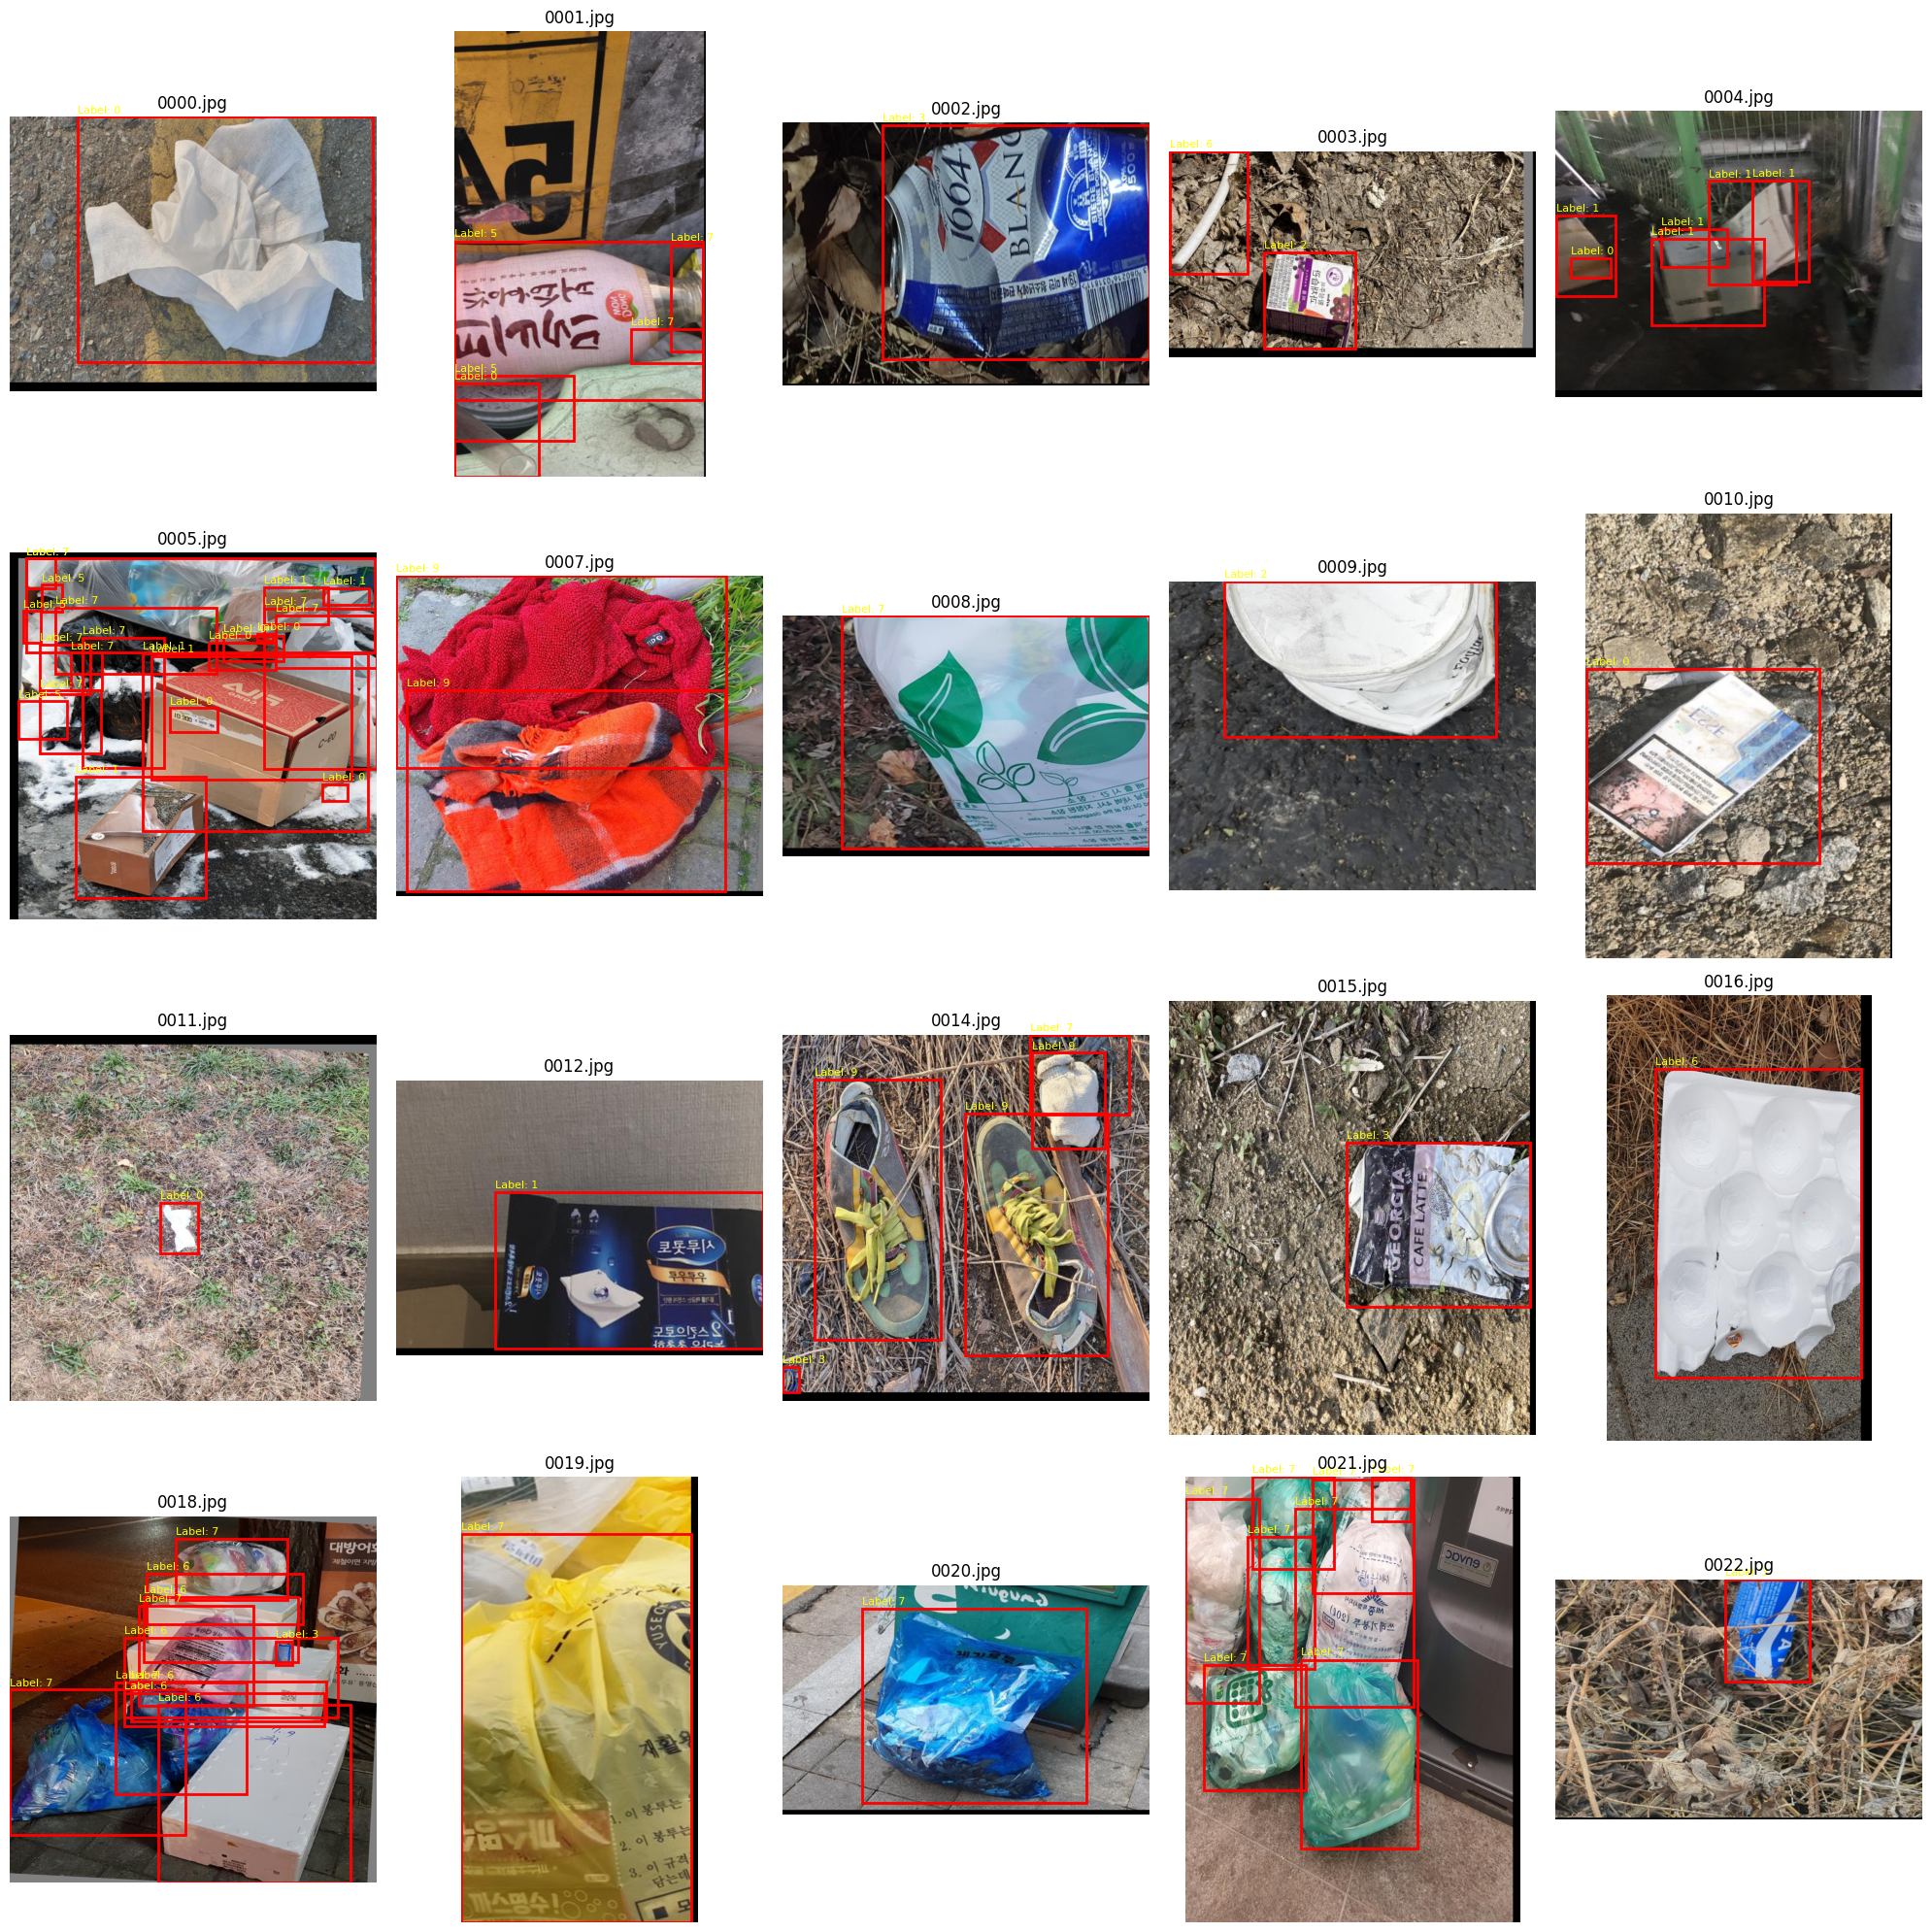

In [7]:
def visualize_selected_images(dataset, indices, cols=5):
    """선택된 인덱스에 해당하는 이미지와 바운딩 박스를 시각화."""
    num_images = len(indices)
    rows = num_images // cols + (num_images % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # 5x4 형태로 시각화
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        # 해당 인덱스 데이터 선택
        data = dataset[idx]

        img = data['img'].data.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        img = img[..., ::-1]  # BGR -> RGB 변환
        img = img.astype(np.uint8)

        gt_bboxes = data['gt_bboxes'].data.numpy()
        gt_labels = data['gt_labels'].data.numpy()

        # 이미지 경로에서 파일명 추출
        img_path = data['img_metas'].data['filename']
        img_name = img_path.split('/')[-1]  # '/'로 split해서 마지막 부분 추출

        # 현재 subplot에 이미지 표시
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')

        # 바운딩 박스 및 라벨 표시
        for bbox, label in zip(gt_bboxes, gt_labels):
            x1, y1, x2, y2 = bbox
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       edgecolor='red', linewidth=2, fill=False))
            # 바운딩 박스 중앙에 라벨 표시
            ax.text(x1, y1 - 5, f'Label: {label}', color='yellow', fontsize=8, va='bottom')

        # 제목으로 이미지 파일명 표시
        ax.set_title(f"{img_name}")

    # 남은 빈 subplot 숨기기
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 원하는 인덱스 20개 지정
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

# 선택된 인덱스의 이미지 시각화
visualize_selected_images(datasets[0], indices=indices)


In [8]:
# 모델 build 및 pretrained network 불러오기
model = build_detector(cfg.model)
model.init_weights()

2024-10-17 15:55:16,553 - mmdet - INFO - load checkpoint from torchvision path: torchvision://resnet50
2024-10-17 15:55:16,687 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2024-10-17 15:55:16,722 - mmdet - INFO - load checkpoint from torchvision path: torchvision://resnet50
2024-10-17 15:55:16,852 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer2.0.rfp_conv.weight, layer2.0.rfp_conv.bias, layer3.0.rfp_conv.weight, layer3.0.rfp_conv.bias, layer4.0.rfp_conv.weight, layer4.0.rfp_conv.bias

2024-10-17 15:55:16,865 - mmdet - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2024-10-17 15:55:16,871 - mmdet - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std'

In [ ]:
# 모델 학습
train_detector(model, datasets[0], cfg, distributed=False, validate=True)

2024-10-17 15:55:19,264 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-10-17 15:55:19,289 - mmdet - INFO - Start running, host: root@instance-12326, work_dir: /data/ephemeral/home/git/level2-objectdetection-cv-03/mmdetection_base/work_dirs/faster_rcnn_base_log
2024-10-17 15:55:19,290 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2024-10-17 15:56:43,601 - mmdet - INFO - Epoch [1][50/490]	lr: 1.978e-03, eta: 2:43:19, time: 1.681, data_time: 0.076, memory: 24186, loss_rpn_cls: 0.8404, loss_rpn_bbox: 0.3371, s0.loss_cls: 3.4699, s0.acc: 86.4108, s0.loss_bbox: 0.1707, s1.loss_cls: 1.1432, s1.acc: 88.9097, s1.loss_bbox: 0.0347, s2.loss_cls: 1.1731, s2.acc: 88.7406, s2.loss_bbox: 0.0067, loss: 7.1759, grad_norm: 971.0000
2024-10-17 15:58:00,720 - mmdet - INFO - Epoch [1][100/490]	lr: 3.976e-03, eta: 2:35:15, time: 1.542, data_time: 0.021, memory: 24186, loss_rpn_cls: 0.1315, loss_rpn_bbox: 0.0556, s0.loss_cls: 0.3601, s0.acc: 94.8367, s0.loss_bbox: 0.1299, s1.loss_cls: 0.1117, s1.acc: 97.4176, s1.loss_bbox: 0.0434, s2.loss_cls: 0.0354, s2.acc: 98.6553, s2.loss_bbox: 0.0074, loss: 0.8751, grad_norm: 7.8214
2024-10-17 15:59:17,631 - mmdet - INFO - Epoch [1][150/490]	lr: 5.974e-03, eta: 2:31:34, time: 1.538, data_time: 0.021, memory: 24186, loss_rpn_cls: 0.1327, loss_rpn_bbox: 0.0623, s0.loss_cls: 0.4091, s0.acc: 94.568